In [6]:
# Jupyter Notebook for Training Q-learning Player in Quixo Game

import random
import numpy as np
from game import Game, Move, Player

class RandomPlayer(Player):
    def __init__(self) -> None:
        super().__init__()

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:
        from_pos = (random.randint(0, 4), random.randint(0, 4))
        move = random.choice([Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT])
        return from_pos, move

class MyPlayer(Player):
    def __init__(self, learning_rate, discount_factor, exploration_prob) -> None:
        super().__init__()
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob
        self.q_values = {}

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:
        state = self.get_state_representation(game)
        
        if np.random.rand() < self.exploration_prob:
            from_pos = (random.randint(0, 4), random.randint(0, 4))
            move = random.choice([Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT])
        else:
            valid_moves = self.get_valid_moves(game)
            action_values = self.q_values.get(state, {action: 0 for action in valid_moves})
            best_action = max(action_values, key=action_values.get)
            from_pos, move = self.decode_action(best_action)

        return from_pos, move

    def get_state_representation(self, game: 'Game') -> str:
        return str(game.get_board().flatten().tolist() + [game.get_current_player()])

    def encode_action(self, from_pos: tuple[int, int], move: Move) -> str:
        return f"{from_pos[0]},{from_pos[1]},{move.value}"

    def decode_action(self, action: str) -> tuple[tuple[int, int], Move]:
        parts = action.split(',')
        return (int(parts[0]), int(parts[1])), Move(int(parts[2]))

    def get_valid_moves(self, game: 'Game') -> list[str]:
        valid_moves = []
        for x in range(5):
            for y in range(5):
                for move in [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]:
                    if game._board[x, y] == -1 or (x == 0 and move == Move.TOP) or (x == 4 and move == Move.BOTTOM) or \
                       (y == 0 and move == Move.LEFT) or (y == 4 and move == Move.RIGHT):
                        valid_moves.append(self.encode_action((x, y), move))
        return valid_moves

    def update_q_values(self, state: str, action: str, reward: int, next_state: str) -> None:
        current_q_value = self.q_values.get(state, {}).get(action, 0)
        max_next_q_value = max(self.q_values.get(next_state, {}).values(), default=0)
        new_q_value = (1 - self.learning_rate) * current_q_value + self.learning_rate * (reward + self.discount_factor * max_next_q_value)
        
        if state not in self.q_values:
            self.q_values[state] = {}
        self.q_values[state][action] = new_q_value

# Training the Q-learning player
def train_q_learning_player(player, num_episodes=1000):
    for _ in range(num_episodes):
        g = Game()
        player.q_values = {}  # Reset Q-values for each episode
        winner = g.play(player, RandomPlayer())
        if winner == 1:
            reward = 1  # Positive reward for winning
        else:
            reward = -1  # Negative reward for losing
        player.update_q_values("", "", reward, "")  # Update Q-values based on the outcome of the episode



In [7]:
#training:
my_player = MyPlayer(0.1,0.9,0.1)
train_q_learning_player(my_player, num_episodes=1000)


TypeError: MyPlayer.__init__() missing 3 required positional arguments: 'learning_rate', 'discount_factor', and 'exploration_prob'

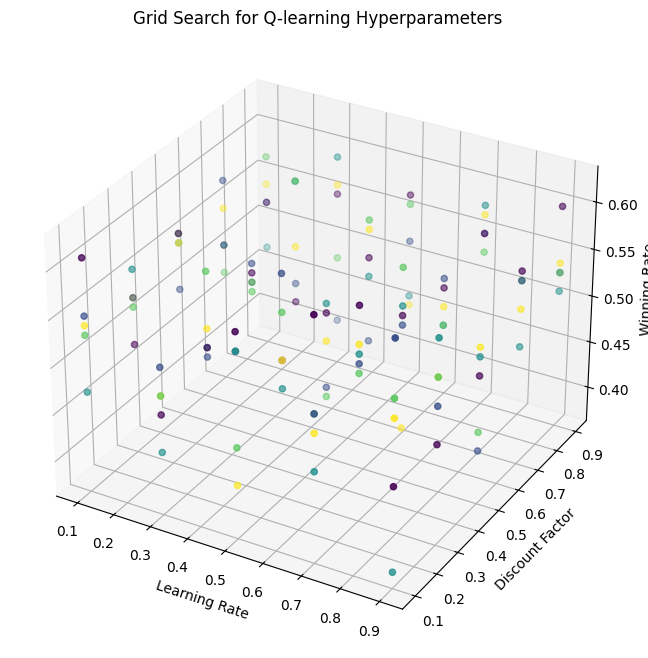

In [8]:
import matplotlib.pyplot as plt
import numpy as np


# Define ranges for hyperparameters
learning_rate_range = np.linspace(0.1, 0.9, 5)
discount_factor_range = np.linspace(0.1, 0.9, 5)
exploration_prob_range = np.linspace(0.1, 0.9, 5)

# Store results
results = []

# Perform grid search
for learning_rate in learning_rate_range:
    for discount_factor in discount_factor_range:
        for exploration_prob in exploration_prob_range:
            # Create and train Q-learning player
            q_learning_player = MyPlayer(learning_rate, discount_factor,exploration_prob)
            train_q_learning_player(q_learning_player, num_episodes=1000)

            # Evaluate winning rate
            num_games = 100
            wins = 0

            for _ in range(num_games):
                game = Game()
                winner = game.play(q_learning_player, RandomPlayer())
                if winner == 0:
                    wins += 1

            winning_rate = wins / num_games
            results.append({
                'learning_rate': learning_rate,
                'discount_factor': discount_factor,
                'exploration_prob': exploration_prob,
                'winning_rate': winning_rate
            })

# Plot results
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

learning_rates = [result['learning_rate'] for result in results]
discount_factors = [result['discount_factor'] for result in results]
exploration_probs = [result['exploration_prob'] for result in results]
winning_rates = [result['winning_rate'] for result in results]

ax.scatter(learning_rates, discount_factors, winning_rates, c=exploration_probs, cmap='viridis')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Discount Factor')
ax.set_zlabel('Winning Rate')
ax.set_title('Grid Search for Q-learning Hyperparameters')

plt.show()


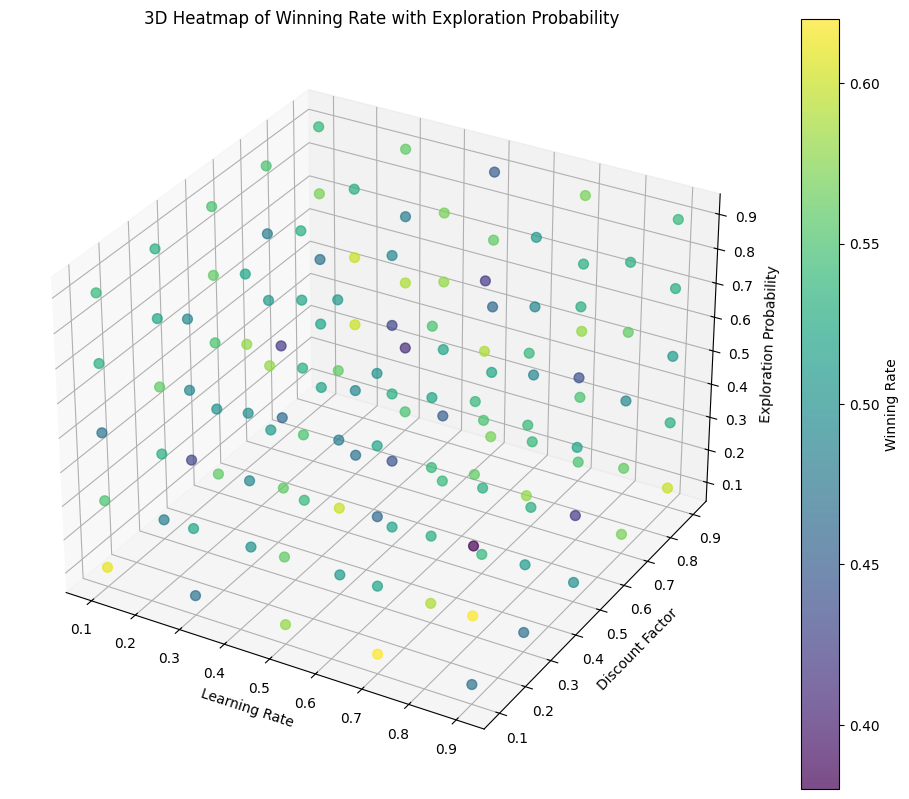

In [18]:
import seaborn as sns

# Convert results to a DataFrame for easier plotting
import pandas as pd
df_results = pd.DataFrame(results)

# 3D Heatmap
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a 3D scatter plot
scatter = ax.scatter(df_results['learning_rate'], df_results['discount_factor'], df_results['exploration_prob'],
                     c=df_results['winning_rate'], cmap='viridis', s=50, alpha=0.7)

# Set labels and title
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Discount Factor')
ax.set_zlabel('Exploration Probability')
ax.set_title('3D Heatmap of Winning Rate with Exploration Probability')

# Add a colorbar
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Winning Rate')

plt.show()


C:\Users\Salma\AppData\Local\Temp\ipykernel_29244\2396195290.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[0, 0].plot(learning_rates, winning_rates, 'o-', markerfacecolor='blue', markersize=8, linestyle='')
C:\Users\Salma\AppData\Local\Temp\ipykernel_29244\2396195290.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[0, 1].plot(discount_factors, winning_rates, 'o-', markerfacecolor='orange', markersize=8, linestyle='')
C:\Users\Salma\AppData\Local\Temp\ipykernel_29244\2396195290.py:17: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[1, 0].plot(exploration_probs, winning_rates, 'o-', markerfacecolo

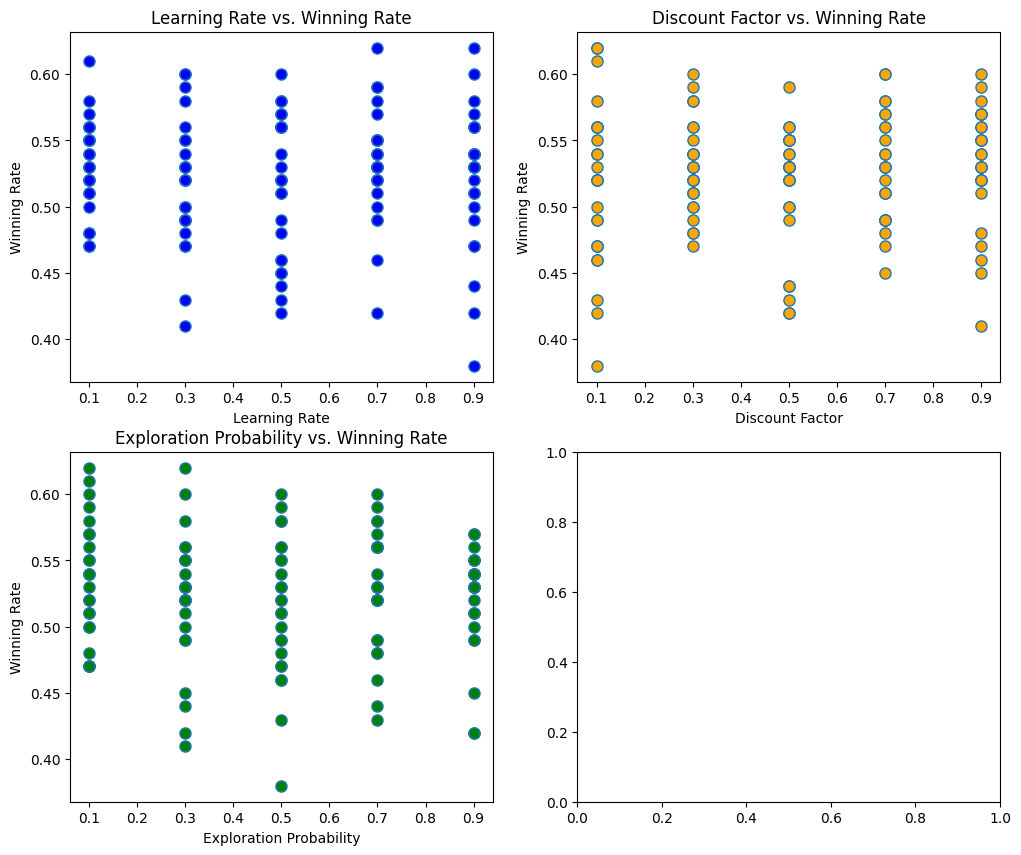

In [20]:
# Plot results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plotting learning_rate vs. winning_rate without lines
axes[0, 0].plot(learning_rates, winning_rates, 'o-', markerfacecolor='blue', markersize=8, linestyle='')
axes[0, 0].set_xlabel('Learning Rate')
axes[0, 0].set_ylabel('Winning Rate')
axes[0, 0].set_title('Learning Rate vs. Winning Rate')

# Plotting discount_factor vs. winning_rate without lines
axes[0, 1].plot(discount_factors, winning_rates, 'o-', markerfacecolor='orange', markersize=8, linestyle='')
axes[0, 1].set_xlabel('Discount Factor')
axes[0, 1].set_ylabel('Winning Rate')
axes[0, 1].set_title('Discount Factor vs. Winning Rate')

# Plotting exploration_prob vs. winning_rate without lines
axes[1, 0].plot(exploration_probs, winning_rates, 'o-', markerfacecolor='green', markersize=8, linestyle='')
axes[1, 0].set_xlabel('Exploration Probability')
axes[1, 0].set_ylabel('Winning Rate')
axes[1, 0].set_title('Exploration Probability vs. Winning Rate')

# Hide the lines connecting points
for ax in axes.flat:
    ax.legend().set_visible(False)

plt.show()


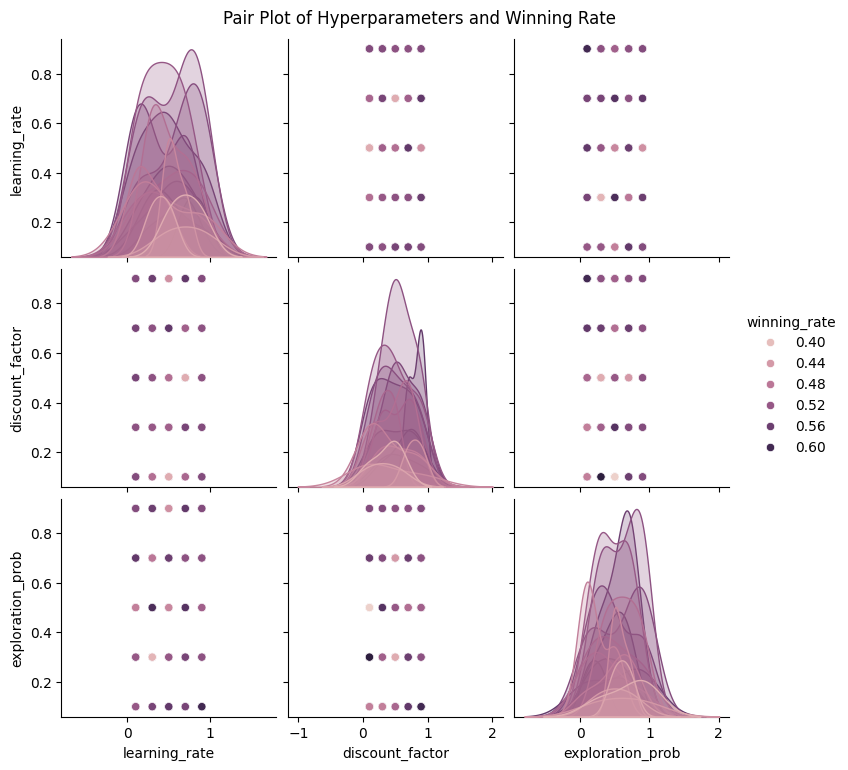

In [23]:
import seaborn as sns

# Convert results to a DataFrame for easier plotting
import pandas as pd
df_results = pd.DataFrame(results)

# Pair Plot
sns.pairplot(df_results, hue='winning_rate', markers='o')
plt.suptitle('Pair Plot of Hyperparameters and Winning Rate', y=1.02)
plt.show()


In [22]:
import numpy as np
from game import Move, Player

class MinimaxPlayer(Player):
    def __init__(self, max_depth=3):
        super().__init__()
        self.max_depth = max_depth

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:
        _, move, from_pos = self.minimax_alpha_beta(game, self.max_depth, float('-inf'), float('inf'), True)
        return from_pos, move

    def minimax_alpha_beta(self, game, depth, alpha, beta, maximizing_player):
        if depth == 0 or game.check_winner() != -1:
            return self.evaluate_board(game), None, None

        legal_moves = game.get_possible_moves()

        if maximizing_player:
            max_eval = float('-inf')
            best_move = None
            best_from_pos = None
            for move in legal_moves:
                next_game = self.simulate_move(game, move)
                eval, _, from_pos = self.minimax_alpha_beta(next_game, depth - 1, alpha, beta, False)
                if eval > max_eval:
                    max_eval = eval
                    best_move = move
                    best_from_pos = from_pos
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break  # Beta cut-off
            return max_eval, best_move, best_from_pos
        else:
            min_eval = float('inf')
            best_move = None
            best_from_pos = None
            for move in legal_moves:
                next_game = self.simulate_move(game, move)
                eval, _, from_pos = self.minimax_alpha_beta(next_game, depth - 1, alpha, beta, True)
                if eval < min_eval:
                    min_eval 


In [26]:
# Assuming my_player has already been created and trained in Cell 2

num_games = 100
wins = 0

for _ in range(num_games):
    g = Game()
    winner = g.play(my_player, RandomPlayer())
    if winner == 0:
        wins += 1

winning_rate = wins / num_games
print(f"Winning Rate: {winning_rate * 100:.2f}%")


Winning Rate: 54.00%


In [ ]:
import numpy as np

class GeneticPlayer(Player):
    def __init__(self, genes=None, mutation_rate=0.1):
        super().__init__()
        self.mutation_rate = mutation_rate
        self.genes = genes if genes is not None else self.initialize_genes()

    def initialize_genes(self):
        # Initialize genes randomly or with some heuristic
        # In this example, genes represent the probability distribution of moves
        return np.random.rand(5, 5, 4)

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:
        # Choose a move based on the probability distribution in genes
        from_pos = self.select_position(game.get_board())
        move = self.select_move()
        return from_pos, move

    def select_position(self, board):
        # Select a position based on the probability distribution in genes
        probabilities = self.genes.flatten()
        probabilities /= probabilities.sum()
        index = np.random.choice(range(len(probabilities)), p=probabilities)
        return np.unravel_index(index, self.genes.shape[:-1])

    def select_move(self):
        # Select a move uniformly at random
        return random.choice([Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT])

    def crossover(self, partner):
        # Perform crossover to create a new player with combined genes
        new_genes = np.zeros_like(self.genes)
        mask = np.random.rand(*self.genes.shape) > 0.5
        new_genes[mask] = self.genes[mask]
        new_genes[~mask] = partner.genes[~mask]
        return GeneticPlayer(genes=new_genes)

    def mutate(self):
        # Mutate genes to introduce diversity
        mask = np.random.rand(*self.genes.shape) < self.mutation_rate
        self.genes[mask] = np.random.rand(*self.genes.shape)[mask]

def evolve_population(population, num_elites=2, mutation_rate=0.1):
    # Sort the population based on fitness
    population.sort(key=lambda player: evaluate_player(player), reverse=True)

    # Select the top players as elites
    elites = population[:num_elites]

    # Perform crossover and mutation to create the next generation
    new_population = elites.copy()
    while len(new_population) < len(population):
        parent1 = random.choice(elites)
        parent2 = random.choice(elites)
        child = parent1.crossover(parent2)
        child.mutate()
        new_population.append(child)

    return new_population

def evaluate_player(player, num_episodes=10):
    # Evaluate the player by playing against random opponents
    total_wins = 0
    for _ in range(num_episodes):
        random_opponent = RandomPlayer()
        game = Game()
        winner = game.play(player, random_opponent)
        if winner == 0:
            total_wins += 1

    return total_wins / num_episodes



In [ ]:
if __name__ == '__main__':
    # Create an initial population of players
    population_size = 10
    initial_population = [GeneticPlayer() for _ in range(population_size)]

    # Evolution loop
    num_generations = 10
    for generation in range(num_generations):
        # Evaluate the fitness of each player in the population
        fitness_scores = [evaluate_player(player) for player in initial_population]

        # Print the average fitness of the generation
        avg_fitness = sum(fitness_scores) / len(fitness_scores)
        print(f"Generation {generation + 1}, Average Fitness: {avg_fitness}")

        # Evolve the population
        initial_population = evolve_population(initial_population)

    # Play the final evolved player against a RandomPlayer
    final_player = max(initial_population, key=lambda player: evaluate_player(player))
    random_opponent = RandomPlayer()

    g = Game()
    g.print()
    winner = g.play(final_player, random_opponent)
    g.print()
    print(f"Winner: Player {winner}")
